# Исследование поведения пользователей мобильного приложения

Описание проекта:
<br>Необходимо проанализировать, как ведут себя пользователи мобильного приложения компании, которая занимается продажей продуктов питания.</br>
<br>Необходимо изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах.</br>
<br>Необходимо исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо определить, какой шрифт лучше.</br>


### Изучение файла и подготовка к анализу

#### Открытие и изучение датасета

In [1]:
# Импортируем необходимые библиотеки 
import pandas as pd
import scipy.stats as stats
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()
import math as mth

In [2]:
#загружаем данные из файла в датафрейм
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
df.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Представленный датафрейм имеет 4 столбца. Содержит в себе данные о событиях, номерах экспериментов, временах событий, уникальных идентификаторах

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропущенных значений нет. Названия столбцов необходимо привести в "змеиный регистр".  В столбце EventTimestamp необходимо поменять тип данных на timestamp

#### Построение общей гистограммы

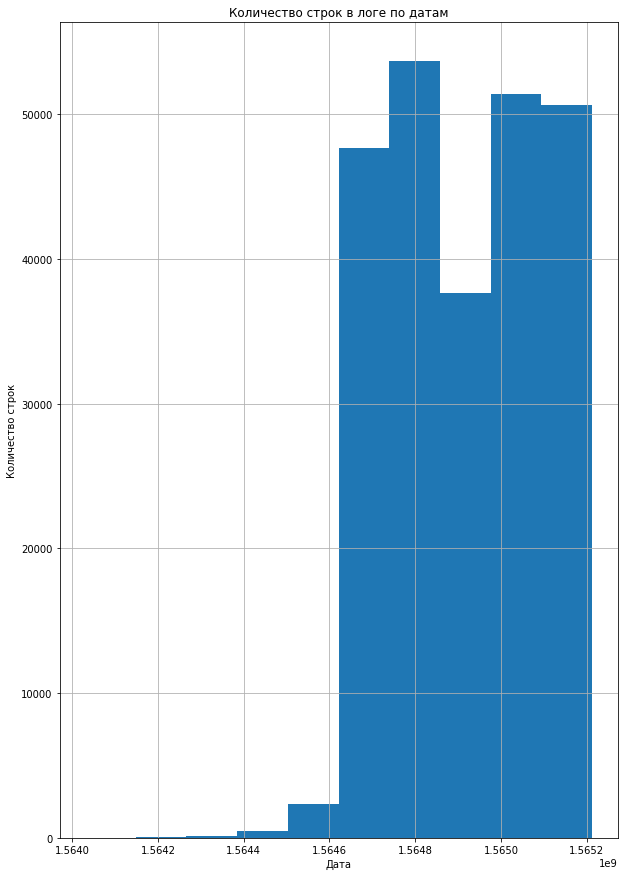

In [4]:
df['EventTimestamp'].hist(figsize=(10,15))
plt.xlabel('Дата')
plt.ylabel('Количество строк')
plt.title('Количество строк в логе по датам')
plt.show()

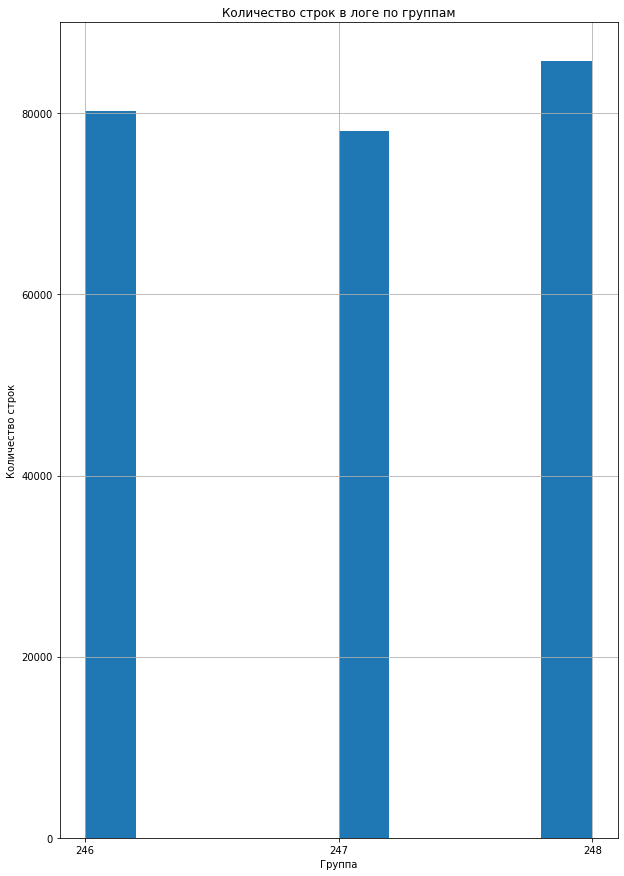

In [5]:
df['ExpId'].hist(figsize=(10,15))
plt.xticks([246, 247, 248])
plt.xlabel('Группа')
plt.ylabel('Количество строк')
plt.title('Количество строк в логе по группам')
plt.show()

Времена событий смещены вправо. После предобработки данных, предстоит узнать, почему произошло такое смещение.
<br> Контрольные группы распределены относительно равномерно. Немного выделяется 248 группа.

In [6]:
# посчитаем кол-во унильных ID пользователей
df['DeviceIDHash'].nunique()

7551

Всего 7551 пользователей соврешали какое-либо действие в приложении

#### Вывод:

Датасет не имеет пропущенных значений. Названия столбцов требуется заменить. Тип данных у столбца со временем некорректен. Данные со временнем смещены вправо. Номера контрольных групп по количеству событий распределены относительно равномерно.

### Предобработка данных

#### Приведение заголовков к "змеиному" регистру

In [7]:
# переименуем названия столбцов
df = df.rename(columns={'EventName': 'event_name', 'DeviceIDHash':'device_id', 'EventTimestamp':'event_time',\
                  'ExpId':'exp_id'})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   device_id   244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


#### Приведение данных в нужный тип

Т.к. данные в столбце event_time представлены в виде unix timestamp, переведем их в datetime

In [9]:
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   device_id   244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


#### Проверка дубликатов

In [11]:
print(df.duplicated().sum())

413


413 явных дубликатов, выведем их 

In [12]:
duplicates_row = df[df.duplicated(keep=False)]
duplicates_row

,event_name,device_id,event_time,exp_id
452,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
2348,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
3572,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
...,...,...,...,...
242359,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246
242634,MainScreenAppear,4097782667445790512,2019-08-07 19:36:58,246


Удалим дубликаты

In [13]:
df= df.drop_duplicates()

In [14]:
print(df.duplicated().sum())

0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   exp_id      243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


Проверим неявные дубликаты

In [16]:
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Проверим события, попавшие в обе группы

In [17]:
df.duplicated(subset=['event_name','device_id','event_time']).sum()

0

Дубликаты удалены

#### Проверка аномальных значений

Снова построим гистограмму по столбцу event_time

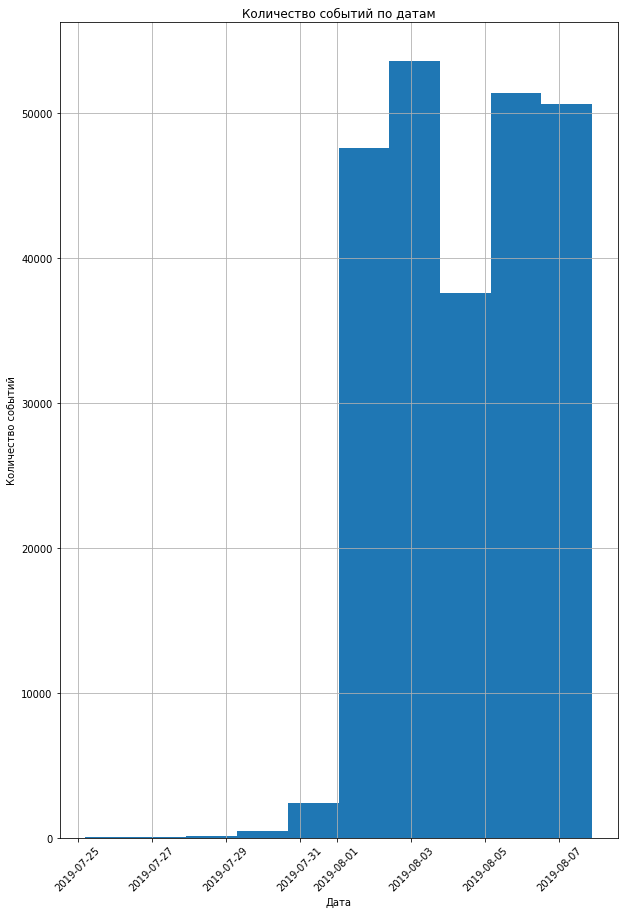

In [18]:
df['event_time'].hist(figsize=(10,15))
plt.xticks(rotation = 45)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Количество событий по датам')
plt.show()

Относительно мало событий с 25.07.2019 по 01.08.2019
<br> Выведем на экран эти строки.</br>
<br>Полными можно называть только данные, начиная с 1 августа 2019 года. До этой даты "доехали" данные из прошлого. </br>
<br>Необходимо отбросить более старые логи

In [19]:
df.query('event_time < "2019-08-01"')

,event_name,device_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
2823,OffersScreenAppear,2413191300976302222,2019-07-31 23:54:55,247
2824,MainScreenAppear,5505110279185484837,2019-07-31 23:57:30,247
2825,MainScreenAppear,5505110279185484837,2019-07-31 23:57:42,247
2826,MainScreenAppear,5505110279185484837,2019-07-31 23:57:52,247


Всего 2826 строк до данной даты. Это чуть более 1 процента

In [21]:
print(df.query('event_time < "2019-08-01"')['device_id'].count()/df['device_id'].count())

0.011595606307418972


Удалим такие данные позднее


Посчитаем долю потерянных уникальных пользователей

In [23]:
print('Кол-во пользователей до фильтрации', df['device_id'].nunique())

Кол-во пользователей до фильтрации 7551


In [24]:
print('Кол-во пользователей после фильтрации', df.query('event_time >= "2019-08-01"')['device_id'].nunique())

Кол-во пользователей после фильтрации 7534


In [25]:
print('Доля отброшенных:', (df['device_id'].nunique()-df.query('event_time >= "2019-08-01"')['device_id'].nunique())\
      /df['device_id'].nunique())

Доля отброшенных: 0.0022513574361011784



Доля отброшенных - 0.2%

Посмотрим уникальные значения в столбце групп

In [26]:
df['exp_id'].unique()

array([246, 248, 247])

Проверим пользователей, входящих в 2 или 3 группы сразу.

In [27]:
df_grouped = df.groupby('device_id').agg({'exp_id' : 'nunique'}).reset_index().query('exp_id>1')['device_id'].unique()
df_grouped

array([], dtype=int64)

Таких пользователей нет

#### Добавим отдельный столбец даты

In [28]:
df['date'] = pd.to_datetime(df['event_time']).dt.date
df.head()

,event_name,device_id,event_time,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


#### Вывод:

Провели предобработку данных. Заменили названия столбцов на змеиный регистр. Поменяли тип в столбце event_time на datetime.
Удалили явные дубликаты. Неявных дубликатов нет. Пользователей, входящих в несколько групп  нет. Добавлен столбец с датой. Больше всего событий произошло в промежуток с 1 по 7 августа 2019 года.

### Изучение и проверка данных

#### Подсчёт событий в логе

Учитывая, что в логе каждая строк равна 1 событию, необходимо посчитать количество строк.

In [29]:
print('Кол-во событий в логе:', len(df))

Кол-во событий в логе: 243713


#### Подсчёт пользователей в логе

In [30]:
print('Кол-во пользователей в логе:', df['device_id'].nunique())

Кол-во пользователей в логе: 7551


#### Подсчёт среднего количества событий на пользователя

In [32]:
print('Среднее кол-во событий на пользователя:', len(df)/df['device_id'].nunique())

Среднее кол-во событий на пользователя: 32.27559263673685


#### Определение периода

In [33]:
print('Минимальная дата:', min(df['date']))

Минимальная дата: 2019-07-25


In [34]:
print('Максимальная дата:', max(df['date']))

Максимальная дата: 2019-08-07


Удалим данные не входящие в необходимый период ">2019-08-01"

In [35]:
# создадим новую переменную data
data = df[(df['event_time'] > '2019-08-01')]
data

,event_name,device_id,event_time,exp_id,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


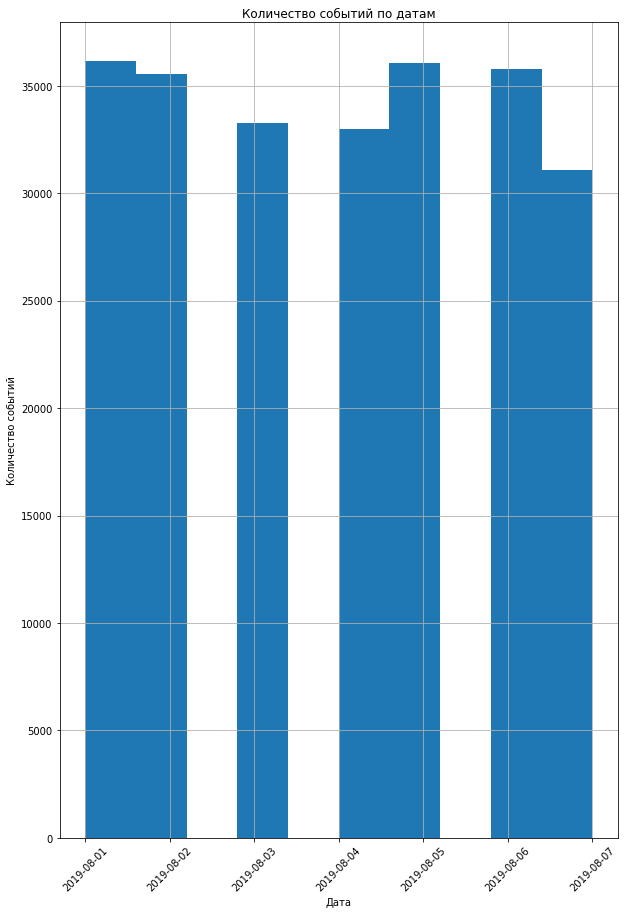

In [36]:
data['date'].hist(figsize=(10,15))
plt.xticks(rotation = 45)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Количество событий по датам')
plt.show()

#### Вывод:

В датасете присутствуют пользователи из всех 3 групп.
<br> Логи по датам до 2019-08-01 являются неподходящими по причине резкого перекоса количества логов. После их удаления, остался период неделя с 1 по 7 августа</br>
<br>Количество пользователей в логе 7551.  Среднее кол-во событий на пользователя по исходных данным: 1.38 </br>
<br> После удаления в логе осталось 240887 событий.</br> Отбросили чуть более 1% логов

### Изучение воронки событий

#### Определение событий в логах

In [37]:
# определим какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.
event_grouped = (
    data.groupby('event_name', as_index=False)['device_id']
    .count()
    .sort_values(by='device_id',ascending=False)
)
event_grouped = event_grouped.rename(columns={'device_id' :'count'})
event_grouped

,event_name,count
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [38]:
# найдём процент каждого события
event_grouped['percentage']=event_grouped['count']/event_grouped['count'].sum()
event_grouped

,event_name,count,percentage
1,MainScreenAppear,117328,0.487067
2,OffersScreenAppear,46333,0.192343
0,CartScreenAppear,42303,0.175613
3,PaymentScreenSuccessful,33918,0.140805
4,Tutorial,1005,0.004172


Чаще всего встречается событие 'MainScreenApper' - открытие основного экрана. Из всего числа событий в 49% случаев.
<br>Далее, по частоте идет 'OffersScreenAppear' - открытие экрана с каталогом - 19% случаев.</br>
<br>Следующее событие 'CartScreenAppear' - открытие корзины - 17.5% случаев</br>
<br>Далее, 'PaymentScreenSuccessful' - экран успешной оплаты - 14.1% случаев</br>
<br>'Tutorial' - обучение - частота 0.4% </br>

####  Сколько пользователей совершали каждое из  событий.  Определение доли пользователей, которые хоть раз совершали событие.

In [39]:
# определим, сколько уникальных пользователей совершали каждое из событий
event_grouped_id = (
    data.groupby('event_name', as_index=False)['device_id']
    .agg({'device_id' : 'nunique'})
    .sort_values(by='device_id',ascending=False)
)
event_grouped_id = event_grouped_id.rename(columns={'device_id':'unique_users_count'})
event_grouped_id

,event_name,unique_users_count
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [41]:
# выведем процент пользователей, которые хоть раз совершали каждое событие\
event_grouped_id['percentage'] = event_grouped_id['unique_users_count']/data['device_id'].nunique()
event_grouped_id

,event_name,unique_users_count,percentage
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


98% пользователей открывали главный экран (7419 пользоваетелей)
<br>61% пользователей открывали каталог (4593 пользоваетеля)</br>
<br>49.5% пользователей открывали корзину (3734 пользоваетеля)</br>
<br>47% пользователям открывался экран успешной оплаты (3539 пользователя)</br>
<br>11.1% пользователей проходили обучение (840 пользователя)


По вероятной воронке, перед открытием главного экрана проходило обучение. Таким образом, некоторые уникальные пользователи не проходили дальше обучения

Также, дело в том, что пользователи могли пройти на страницы товаров по прямой ссылке.


Предположим, что события происходят в порядке: "Прохождение обучения"-"Открытие главного экрана"-"Открытие каталога"-"Переход в корзину"-"Открытие экрана успешной оплаты заказа"
<br> Предположим, что не все действия обязательны к выполнению. Например, обучение большинство пользователей не проходит. </br>
<br> Возможна вторая воронка: "Открытие главного экрана" - "Открытие каталога" - "Переход в корзину" - "Успешная оплата"</br>
<br> Таким образом, прохождение обучения можно не учитывать при расчёте воронки

In [42]:
#удалим из таблицы значения Tutorial
event_grouped_id = event_grouped_id.query('event_name != "Tutorial"')
event_grouped_id

,event_name,unique_users_count,percentage
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737


#### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

<b>"Открытие главного экрана" - "Открытие каталога" - "Перемещение заказа в корзину" - "Оплата заказа"</b>

In [43]:
# добавим новый столбец со значением пользователей из предыдущего шага
event_grouped_id['prev_value'] = event_grouped_id['unique_users_count'].shift(1)
event_grouped_id

/tmp/ipykernel_667/181386400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_grouped_id['prev_value'] = event_grouped_id['unique_users_count'].shift(1)


,event_name,unique_users_count,percentage,prev_value
1,MainScreenAppear,7419,0.984736,NaN
2,OffersScreenAppear,4593,0.609636,7419.0
0,CartScreenAppear,3734,0.495620,4593.0
3,PaymentScreenSuccessful,3539,0.469737,3734.0


In [44]:
# посчитаем процент пользователей, которые проходят на следующий этап
event_grouped_id['next_users_acquisition'] = event_grouped_id['unique_users_count']/event_grouped_id['prev_value']
event_grouped_id

/tmp/ipykernel_667/1209188793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_grouped_id['next_users_acquisition'] = event_grouped_id['unique_users_count']/event_grouped_id['prev_value']


,event_name,unique_users_count,percentage,prev_value,next_users_acquisition
1,MainScreenAppear,7419,0.984736,NaN,NaN
2,OffersScreenAppear,4593,0.609636,7419.0,0.619086
0,CartScreenAppear,3734,0.495620,4593.0,0.812976
3,PaymentScreenSuccessful,3539,0.469737,3734.0,0.947777


Таким образом, после главного экрана открывают каталог только 62% пользователей. Те, кто открыли каталог, закидывают товар в корзину и переходя в неё в 81% случаев. После этого, оплачивают заказ в 95 % случаев

Больше всего пользователей теряется после первого шага - 38%.

In [45]:
# посчитаем долю пользователей, который доходят от открытие главного экрана до оплаты
acquisition = 3539/7419
print('Доля пользователей, которые доходят до оплаты  {:2.2%}'.format(acquisition))

Доля пользователей, которые доходят до оплаты  47.70%


Можно сделать вывод, что больше половины пользователей не доходят до оплаты заказа.

#### Вывод:

Самое частое событие 'MainScreenApper' - открытие основного экрана. Из всего числа событий в 49% случаев.
<br>Самое нечастое событие 'Tutorial' - обучение - частота всего 0.4%</br>
<br> 98% из всего числа пользователей хотя бы раз открывали главный экран (7419 пользоваетелей)</br>
<br> На основе данных, предположено, что порядок событий: "Открытие главного экрана" - "Открытие каталога" - "Переход в корзину" - "Успешная оплата"</br>
<br> После открытия главного экрана, открывают каталог только 62% пользователей. Те, кто открыли каталог, закидывают товар в корзину и переходят в неё в 81% случаев. После этого, оплачивают заказ в 95 % случаев.</br>
<br> После первого шага теряется 38% пользователей.</br>
<br> Доля пользователей, которые доходят от первого этапа до оплаты  - 47.7%</br>

### Изучение результатов эксперимента

#### Подсчёт пользователей в каждой экспериментальной группе

2 контрольные группы 246 и 247 со старыми шрифтами. Одна контрольная группа экспериментальная с новыми шрифтами — 248

In [46]:
# сгруппируем по каждой группе и посчитаем уникального число пользователей
users_grouped = data.groupby('exp_id', as_index=False).agg({'device_id' : 'nunique'})
users_grouped

,exp_id,device_id
0,246,2484
1,247,2513
2,248,2537


В группе 246 - 2484 пользователя.
<br> В группе 247 - 2513 пользователей.</br>
<br>В группе 248 - 2537 пользователей </br>

#### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.


Выдвигаем нулевую и альтернативную гипотезы:
<br><b>H0 - Статистически значимых различий конверсии в покупателей между группами нет</b></br>
<br><b>H1 - Статистически значимых различий конверсии в покупателей между группами  присутствуют</b></br>
<br> Выберем уровень статической значимости 0.05 по причине относительно большого количества тестов на одной и той же выборке. Проверим гипотезы о равенстве долей. Посчитаем статистику в стандартных отклонениях стандартного нормального распределения. Проверять гипотезу о равенстве долей будем при помощи Z-критерия


In [47]:
# создадим датасеты для групп
group_246 = data.query('(exp_id == 246)&(event_name != "Tutorial")')
# создадим датасет для подсчёта пользователей для каждого event_name
data_246 = group_246.groupby('event_name').agg({'device_id':'nunique'}).reset_index().sort_values(by='device_id', ascending = False)
data_246 = data_246[data_246['event_name'] != 'Tutorial']
data_246


,event_name,device_id
1,MainScreenAppear,2450
2,OffersScreenAppear,1542
0,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200


In [48]:
# зафиксируем заход на главный экран и покупки
trials_246 = data_246.device_id[0]
successes_246 = data_246.device_id[3]
 
# сделаем тоже самое для 247 группы
group_247 = data.query('(exp_id == 247)&(event_name != "Tutorial")')
data_247 = group_247.groupby('event_name').agg({'device_id':'nunique'}).reset_index().sort_values(by='device_id', ascending = False)
data_247 = data_247[data_247['event_name'] != 'Tutorial']
trials_247 = data_247.device_id[0]
successes_247 = data_247.device_id[3]
 
alpha = .05 # критический уровень статистической значимости
 
# Пропорция успехов во группах
p1 = successes_246/trials_246
p2 = successes_247/trials_247
 
# Пропорция успехов в комбинированном датасете:
p_combined = (successes_246 + successes_247)/(trials_246 + trials_247)
 
# разница пропорций в датасетах
p_diff = p1 - p2
 
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = p_diff / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_246 + 1/trials_247))
 
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = stats.norm(0, 1)
 
p_value = (1 - distr.cdf(abs(z_value))) * 2
 
print('p-значение:',p_value)
 
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть различия в конверсии")

p-значение: 0.18243439408067652
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть различия в конверсии


Разница не оказалось значимой. Группы 246 и 247 можно считать контрольными.

#### Посчитаем количество пользователей совершивших то или иное действие в каждой из контрольных групп. Проверим, будет ли отличие между группами статистически достоверным

Создадим комбинированный датасет из контрольных групп

In [49]:
groups_combined = data_247.merge(data_246, on='event_name')
groups_combined= groups_combined.rename(columns=({'device_id_x' : 247, "device_id_y":246}))
groups_combined

,event_name,247,246
0,MainScreenAppear,2476,2450
1,OffersScreenAppear,1520,1542
2,CartScreenAppear,1238,1266
3,PaymentScreenSuccessful,1158,1200


выдвигаем нулевую и альтернативную гипотезы:
<br><b>H0 - Статистически значимых различий в доле пользователей  совершивших какое-либо событие между группами нет  </b></br>
<br><b>H1 - Статистически значимые различия в доле пользователей  совершивших какое-либо событие между группами присутствуют</b></br>

In [50]:
groups_combined[246][0]/float(users_grouped[users_grouped['exp_id']==246]['device_id'])

0.9863123993558777

In [51]:
# создадим функцию для быстрого посчёта стат значимости
def stat_value(first_group, second_group, alpha):
    for row in groups_combined.index:
        alpha=alpha
        # посчитаем долю от всего числа пользователей для первой группы
        p1 = groups_combined[first_group][row]/float(users_grouped[users_grouped['exp_id']==first_group]['device_id'])
        # для второй группы
        p2 = groups_combined[second_group][row]/float(users_grouped[users_grouped['exp_id']==second_group]['device_id'])
        # Пропорция успехов в комбинированном датасете:
        p_combined = ((groups_combined[first_group][row] + groups_combined[second_group][row]) / 
                      (float(users_grouped[users_grouped['exp_id']==first_group]['device_id']) \
                       + float(users_grouped[users_grouped['exp_id']==second_group]['device_id'])))
 
        # разница пропорций в датасетах
        p_diff = p1 - p2
 
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = p_diff / mth.sqrt(p_combined * (1 - p_combined) \
                                    * (1/float(users_grouped[users_grouped['exp_id']==first_group]['device_id']) \
                                       + 1/float(users_grouped[users_grouped['exp_id']==second_group]['device_id'])))
 
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = stats.norm(0, 1)
 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
 
        print('{} p-value:{}'.format(groups_combined['event_name'][row], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами")
        print("")

In [52]:
stat_value(246, 247, 0.05)

MainScreenAppear p-value:0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

OffersScreenAppear p-value:0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

CartScreenAppear p-value:0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

PaymentScreenSuccessful p-value:0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами



По всем событиям подтвердилась нулевая гипотеза
<br>Отличие между группами статистически не значимы.</br> Обе группы можно считать контрольными

#### Сравним каждую из контрольных групп с экспериментальной

<b>Сравним группы 246 и 248</b>

In [53]:
# создадим группу 248
group_248 = data.query('(exp_id == 248)&(event_name != "Tutorial")')
data_248 = group_248.groupby('event_name').agg({'device_id':'nunique'}).reset_index().sort_values(by='device_id', ascending = False)
data_248 = data_248[data_248['event_name'] != 'Tutorial']
data_248

,event_name,device_id
1,MainScreenAppear,2493
2,OffersScreenAppear,1531
0,CartScreenAppear,1230
3,PaymentScreenSuccessful,1181


In [54]:
groups_combined = groups_combined.merge(data_248, on='event_name')
groups_combined = groups_combined.rename(columns=({'device_id' : 248}))
groups_combined

,event_name,247,246,248
0,MainScreenAppear,2476,2450,2493
1,OffersScreenAppear,1520,1542,1531
2,CartScreenAppear,1238,1266,1230
3,PaymentScreenSuccessful,1158,1200,1181


In [55]:
stat_value(246, 248, 0.05)

MainScreenAppear p-value:0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

OffersScreenAppear p-value:0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

CartScreenAppear p-value:0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

PaymentScreenSuccessful p-value:0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами



Нет значимых различий между контрольной группой 246 и экспериментальной группой.

<b>Сравним группы 247 и 248</b>

In [57]:
stat_value(247, 248, 0.05)

MainScreenAppear p-value:0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

OffersScreenAppear p-value:0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

CartScreenAppear p-value:0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

PaymentScreenSuccessful p-value:0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами



Снова нет значимых различий между контрольной группой 247 и экспериментальной группой.

#### Сравним объединенные контрольные группы с экспериментальной

Выдвигаем нулевую и альтернативную гипотезы:
<br>H0 - Статистически значимых различий в доле пользователей совершивших какое-либо событие между объединенными контрольными группами и экспериментальной группой нет</br>
<br>H1 - Статистически значимые различия в доле пользователей совершивших какое-либо событие между объединенными контрольными группами и экспериментальной группой присутствуют</br>

In [58]:
groups_combined[247+246]=groups_combined[246]+groups_combined[247]

In [59]:
groups_combined

,event_name,247,246,248,493
0,MainScreenAppear,2476,2450,2493,4926
1,OffersScreenAppear,1520,1542,1531,3062
2,CartScreenAppear,1238,1266,1230,2504
3,PaymentScreenSuccessful,1158,1200,1181,2358


In [60]:
print(2484+2513, 'всего уникальных пользователей в объединенной группе ')

4997 всего уникальных пользователей в объединенной группе 


In [61]:
sum_of_groups = users_grouped['device_id'][0]+users_grouped['device_id'][1]
print(sum_of_groups, 'всего уникальных пользователей в объединенной группе ')

4997 всего уникальных пользователей в объединенной группе 


In [62]:
new_row = {'exp_id':246+247, 'device_id':sum_of_groups}
users_grouped = users_grouped.append(new_row, ignore_index=True)
users_grouped

,exp_id,device_id
0,246,2484
1,247,2513
2,248,2537
3,493,4997


In [63]:
stat_value(493, 248, 0.05)

MainScreenAppear p-value:0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

OffersScreenAppear p-value:0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

CartScreenAppear p-value:0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами

PaymentScreenSuccessful p-value:0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что есть значимые различия между группами



Также, нет значимых различий между объединенной контрольной группой и экспериментальной

#### Вывод:

Был выбран уровень статистической значимости - 0.05. При таком уровне значимости, каждый 20 тест можно получить ложноположительный результат
<br> Было проведено 17 тестов. Можно сделать вывод, что нет оснований полагать, что какой-либо из тестов был ложным.</br>
<br></br>
<br>В представленном логе в 246 группе- 2484 пользователя. В группе 247 - 2513 пользователей. В группе 248 - 2537 пользователей.
<br> Был проведён тест, на основании которого не получилось отвергнуть нулевую гипотезу при которой нет оснований считать что есть различия в конверсии между группами 246 и 247.</br> Обе группы можно считать контрольными.
<br>Также, не получилось отвергнуть нулевую гипотезу при которой можно утверждать, что нет оснований считать что есть значимые различия в доле пользователей совершивших какое-либо событие между группами 246 и 247; 246 и 248; 247 и 248.</br>
<br>При сравнении объединенной контрольной группы и экспериментальной группы, также, не получилось отвергнуть ту же нулевую гипотезу</br>
<br> Можно считать, что тест прошёл успешно. Изменение шрифта никак не повлияло на поведение пользователей.</br>
<br></br>
<br>При отсутствии острой необходимости замены шрифта(обусловленной дизайнерскими/функциональными решениями и т.п.), можно порекомендовать оставить старый, с целью предотвращения потенциальных технических неполадок при внедрении изменения.</br>

### Вывод

<br>Был проведён анализ, как ведут себя пользователи мобильного приложения компании</br> 
<br>Была изучена воронка продаж. Определено, как пользователи доходят до покупки.</br>
<br>Проведено исследование результатов A/A/B-эксперимента по замене шрифта в приложении.</br>
<br>Количество пользователей в предоставленном логе 7551 человек. </br>
<br>Среднее кол-во событий на пользователя по исходных данным: <b>32.27</b></br>
<br>В процессе изучения было выявлено, что самое частое событие 'MainScreenApper' - открытие основного экрана. Из всего числа событий встречается в 49% случаев.</br>Меньше всего пользователи проходили этап обучения.
<br> В целом, <b>98%</b>(7419) пользователей хотя бы раз открывали главный экран. 
<br> Предположительно, порядок событий в воронке состоит из следующих этапов: "Открытие главного экрана" - "Открытие каталога" - "Переход в корзину" - "Успешная оплата", без учёта прохождения обучения.
<br>- После открытия главного экрана, открывают каталог только 62% пользователей; </br>
<br>- После открытия каталога, переходят в корзину 81% пользователей; </br> 
<br>- После перехода в корзину, оплачивают заказ в 95 % пользователей.</br>
Больше всего теряется пользователей после первого шага <b>38%</b>.
<br><b>Доля пользователей, которые доходят от первого этапа до оплаты - 47.7%</b></br>
<br>Количество пользователей в группах: </br>
<br><b>- 246 группа - 2484 пользователя. </br>
<br>- 247 группа - 2513 пользователя.</br>
<br>- 248 группа - 2537 пользователей.</b></br>
<br>Был проведён тест, на основании которого не получилось отвергнуть нулевую гипотезу при которой нет оснований считать что есть различия в конверсии между группами 246 и 247. Принято решение считать обе группы контрольными</br>
<br>Не получилось отвергнуть нулевую гипотезу при которой можно утверждать, что нет оснований считать что есть значимые различия в доле пользователей совершивших какое-либо событие между группами 246 и 247; 246 и 248; 247 и 248.</br>
<br>При сравнении объединенной контрольной группы и экспериментальной группы, также, не получилось отвергнуть ту же нулевую гипотезу при которой можно утверждать, что нет оснований считать, что есть значимые различия в доле пользователей совершивших какое-либо событие.</br>
Исходя из вышеперечисленного, можно считать, тест прошёл успешно. Изменение шрифта никак не повлияло на поведение пользователей.
<br>При отсутствии острой необходимости замены шрифта(обусловленной дизайнерскими/функциональными решениями и т.п.), можно порекомендовать оставить старый, с целью предотвращения потенциальных технических неполадок при внедрении изменения.</br>